### exp: eqtl prediction, slope prediction, gpn for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = ['small']
model_list = ['MLP', 'CNN', 'RNN']
tissue = 'CD4'
data_path = '../../../../../datasets_embedding/gpn/meqtl_datasets/slope_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed1030/'
# set seed
seed = 1030
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['Beta'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['Beta'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

          CpG              SNP      Beta Ref Alt   CHR    CpG_POS    SNP_POS  \
0  cg13250850   1:76251746_T_C  1.731170   T   C  chr1   76250734   76251746   
1  cg22992797  1:213180791_G_A -2.291613   G   A  chr1  213181989  213180791   
2  cg18815120  1:231505587_T_A  1.516844   T   A  chr1  231512676  231505587   
3  cg12835689   1:94063844_C_A -2.829600   C   A  chr1   94057740   94063844   
4  cg18621232   1:31677346_C_T  3.458530   C   T  chr1   31681696   31677346   

                                          seq_before  \
0  ggcctcctaggcatgcagaactgtgagtcaattggacttatttcct...   
1  gagtagctgggactacaggcgcccaccaccacacctagctaatttt...   
2  AGTTAAAGAAAAGAAGGTAAGTGGTCCATCAGATGGGAAACAGACC...   
3  GAGTGAGGCCAGATGGATCCCCTCCTTCCAAACCTACAAAAGCCAG...   
4  CGCCAACCCCAGGAGCCCACACAAGGTGGGGAGTGAGGGACAAGGG...   

                                           seq_after  seq_len  \
0  ggcctcctaggcatgcagaactgtgagtcaattggacttatttcct...    20001   
1  gagtagctgggactacaggcgcccaccaccacacctagctaatttt...

##### model 1: mlp

rmse= 3.047929312443713
r2= 0.031157893630622824
pcc= 0.20542222077864092
pcc_p= 3.720769714421065e-05


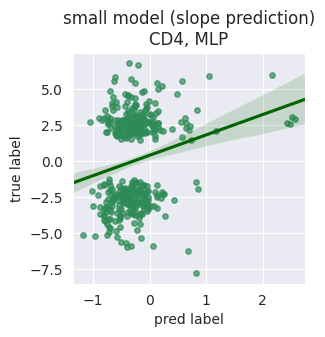

In [4]:
# model 1: mlp
from sklearn.neural_network import MLPRegressor
ml_model = model_list[0]
mlp = MLPRegressor(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_pred = mlp.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

2024-11-11 20:37:12.384271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 20:37:12.396861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 20:37:12.400701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 20:37:12.411375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 20:37:13.117920: W tensorflow/comp

rmse= 2.689773574054505
r2= 0.2454732019500654
pcc= 0.5020174529189746
pcc_p= 9.830074851785677e-27


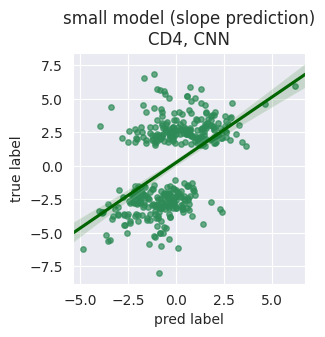

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasRegressor(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = cnn.predict(X_test_reshape)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

rmse= 3.0750522227213235
r2= 0.013838110048734809
pcc= 0.19966008758055204
pcc_p= 6.173931076258344e-05


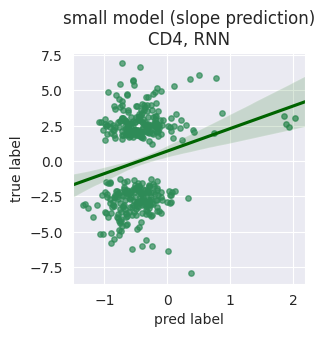

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasRegressor(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = rnn.predict(X_test_reshape)

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()